# Cámara 2 — Detección de rostro con OpenCV (Haar Cascade)

Este notebook detecta el **rostro** usando **OpenCV** (Haar Cascade) sin MediaPipe.

- Para pruebas con imágenes: coloque archivos en `data_face/` (o cambie `DATA_DIR`).
- Para webcam: ajuste `CAM_INDEX`.
- Evidencias: se guardan en `evidencias_face_haar/`.


In [1]:
#Importamos librerías
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob, os, time

DATA_DIR = "data_face"  #carpeta de imágenes para pruebas


In [2]:
#Funcion para mostrar imágenes (BGR -> RGB)
def show(img, title="", cmap=None, figsize=(6,4)):
    plt.figure(figsize=figsize)
    if img.ndim == 2:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()


Imágenes: 2


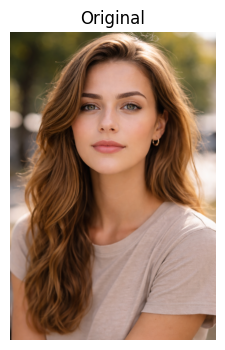

In [9]:
#Cargamos imagenes de prueba
paths = sorted(glob.glob(DATA_DIR + "/*"))
print("Imágenes:", len(paths))

idx = 0  #numero de imagen
img = cv2.imread(paths[idx]) if len(paths) > 0 else None

if img is None:
    print("No se pudo leer la imagen. Revisa DATA_DIR o idx.")
else:
    show(img, "Original")


In [4]:
#Inicializamos detector de rostro (Haar Cascade)
#Nota: este modelo viene con OpenCV. No requiere descargas extra.
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

if face_cascade.empty():
    raise RuntimeError("No se pudo cargar haarcascade_frontalface_default.xml")


In [5]:
#Algoritmo 2 (Cámara 2): detección de rostro
def detect_face_haar(frame_bgr):
    gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)
    #Mejora leve para iluminación
    gray = cv2.equalizeHist(gray)

    faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=6,
        minSize=(80, 80)
    )

    out = frame_bgr.copy()
    boxes = []
    for (x, y, w, h) in faces:
        boxes.append((x, y, x+w, y+h))
        cv2.rectangle(out, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(out, "Face", (x, max(0, y-10)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)
    return out, boxes


In [6]:
#ROI de boca aproximado
def mouth_roi_from_face_bbox(face_bbox):
    x1, y1, x2, y2 = face_bbox
    w = x2 - x1
    h = y2 - y1
    #Boca suele estar en el tercio inferior del rostro
    mx1 = x1 + int(0.20 * w)
    mx2 = x1 + int(0.80 * w)
    my1 = y1 + int(0.62 * h)
    my2 = y1 + int(0.92 * h)
    return (mx1, my1, mx2, my2)

def draw_mouth_roi(frame_bgr, boxes):
    out = frame_bgr.copy()
    mouth_center = None
    if not boxes:
        return out, mouth_center
    #Usamos el rostro más grande
    boxes = sorted(boxes, key=lambda b: (b[2]-b[0])*(b[3]-b[1]), reverse=True)
    face = boxes[0]
    mx1, my1, mx2, my2 = mouth_roi_from_face_bbox(face)
    cv2.rectangle(out, (mx1, my1), (mx2, my2), (0, 0, 255), 2)
    cv2.putText(out, "Mouth ROI", (mx1, max(0, my1-10)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)
    mouth_center = (int((mx1+mx2)/2), int((my1+my2)/2))
    cv2.circle(out, mouth_center, 5, (255, 0, 0), -1)
    return out, mouth_center


Caras detectadas: 1
Mouth center: (499, 577)


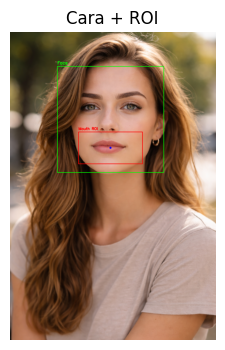

In [10]:
#Probamos con una imagen
if img is not None:
    out, boxes = detect_face_haar(img)
    out2, mouth_center = draw_mouth_roi(out, boxes)
    print("Caras detectadas:", len(boxes))
    print("Mouth center:", mouth_center)
    show(out2, "Cara + ROI")


In [8]:
#Probamos con camara de la compu
CAM_INDEX = 0  
os.makedirs("evidencias_face_haar", exist_ok=True)

cap = cv2.VideoCapture(CAM_INDEX)
if not cap.isOpened():
    raise RuntimeError("No se pudo abrir la cámara. Cambie CAM_INDEX.")

while True:
    ok, frame = cap.read()
    if not ok:
        break

    out, boxes = detect_face_haar(frame)
    out2, mouth_center = draw_mouth_roi(out, boxes)

    cv2.imshow("Camara 2 - Rostro (OpenCV)", out2)

    key = cv2.waitKey(1) & 0xFF
    if key in (27, ord('q')):
        break

cap.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 